## Libraries and Environment

In [ ]:
# to run in google colab
# import sys
# if 'google.colab' in sys.modules:
#     import subprocess
#     subprocess.call("pip install -U opencv-python".split())

In [ ]:
!pip install -U opencv-contrib-python

     |████████████████████████████████| 66.7 MB 19 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import distance
import copy
import heapq
import cv2
from tqdm.notebook import tqdm, trange

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import CIFAR10 Dataset

In [ ]:
# function for unpickling the CIFAR10 dataset
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

Note: Each row of the "images" array produced below stores one of the 60,000 32x32 color images. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

In [ ]:
# import CIFAR10 image batches
DATA_ROOT = "/content/drive/Shareddrives/504 Project/CIFAR10/cifar-10-batches-py/"
batch1 = unpickle(DATA_ROOT + "data_batch_1")
batch2 = unpickle(DATA_ROOT + "data_batch_2")
batch3 = unpickle(DATA_ROOT + "data_batch_3")
batch4 = unpickle(DATA_ROOT + "data_batch_4")
batch5 = unpickle(DATA_ROOT + "data_batch_5")
test_batch = unpickle(DATA_ROOT + "test_batch")

images = np.concatenate([batch1[b'data'], batch2[b'data'], batch3[b'data'], batch4[b'data'], batch5[b'data'], test_batch[b'data']])


# convert image bytes to imgs
#images_rgb = np.zeros((len(images), 32, 32, 3))
#for i in range(len(images)):
  #im = images[i]
  #im_r = im[0:1024].reshape(32, 32)
  #im_g = im[1024:2048].reshape(32, 32)
  #im_b = im[2048:].reshape(32, 32)
  #im_rgb = np.dstack((im_r, im_g, im_b)) / 255.0
  #images_rgb[i,:,:,:] = im_rgb
  
#images = images_rgb

# confirm correct size of data array
print("Data dimensions: ", np.shape(images))

Data dimensions:  (60000, 3072)


## Visualize CIFAR

In [ ]:
## functions for displaying cifar images
def cifar10_plot_single(data, im_idx=0):
    im = data[im_idx, :]
    
    im_r = im[0:1024].reshape(32, 32)
    im_g = im[1024:2048].reshape(32, 32)
    im_b = im[2048:].reshape(32, 32)

    img = np.dstack((im_r, im_g, im_b))

    print("shape: ", img.shape)        
    
    plt.imshow(img) 
    plt.show()

def cifar10_plot_examples(data):
  
  for i in range(9):
    im = data[i, :]
    im_r = im[0:1024].reshape(32, 32)
    im_g = im[1024:2048].reshape(32, 32)
    im_b = im[2048:].reshape(32, 32)

    img = np.dstack((im_r, im_g, im_b))
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(img)

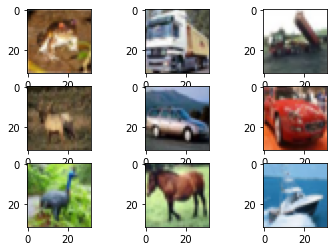

In [ ]:
cifar10_plot_examples(images)

shape:  (32, 32, 3)


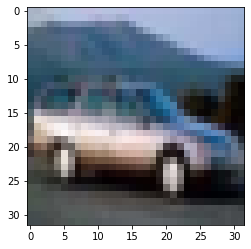

In [ ]:
cifar10_plot_single(images, im_idx=4)

## Perform Dimensionality Reduction on Image Feature Vectors

  0%|          | 0/60000 [00:00<?, ?it/s]

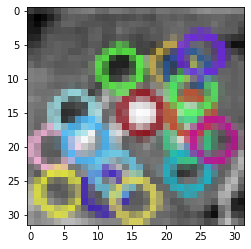

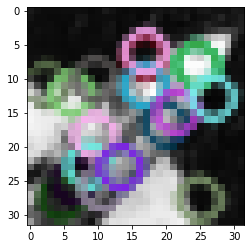

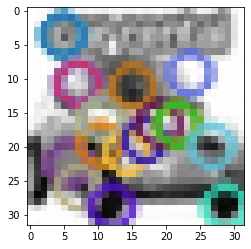

0 35
sift_feats.shape (60000, 256)
[0.1469126  0.04880408 0.04307774 0.03573114 0.02999981 0.02902611
 0.02575904 0.02476882 0.02254315 0.01912751 0.01754207 0.01601445
 0.01553166 0.01455342 0.01378454 0.01321756 0.01241304 0.01189007
 0.01118926 0.01077644]


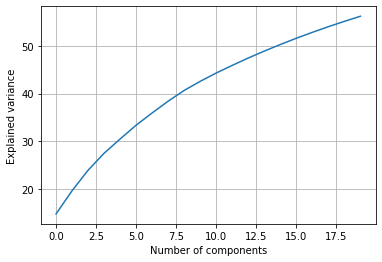

In [ ]:
# using sift for better feature extraction first (scale invariance, rotation)
# and then pca on it for final dimensionality reduction
def pca_sift_reduce(images, n_components, num_kp=5):
  sift_feats = []
  keypoint_lens = []
  
  for i in trange(len(images)):
    img = (images[i] * 255).astype('uint8')    
    sift = cv2.SIFT_create()
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    keypoints, des = sift.detectAndCompute(img, None)

    if i % 20000 == 0: # show some examples
      img_kp = cv2.drawKeypoints(gray, keypoints, img)
      plt.imshow(img_kp)
      plt.show()

    keypoint_lens.append(len(keypoints))
    
    responses = []
    for kp in keypoints:
      # final_sift_features.append([kp.size, kp.angle, kp.pt[0], kp.pt[1], kp.overlap, kp.response, kp.octave]) # angle, size, x, y features from sift keypoint
      responses.append(kp.response) # angle, size, x, y features from sift keypoint

    top_k_des = np.zeros((num_kp, 128))

    if des is None: # could not find descriptors / kp
      #continue
      sift_feats.append(top_k_des.flatten()) # append as empty
    else:
      responses_des = zip(responses, des) # compute top k keypoints by highest responses sorted
      j = 0
      for r,d in sorted(responses_des, key=lambda x: x[0], reverse=True):
        top_k_des[j] = d
        j += 1
        if j == num_kp:
          break
    
      sift_feats.append(top_k_des.flatten())

  print(min(keypoint_lens), max(keypoint_lens))  

  sift_feats = np.array(sift_feats)
  print('sift_feats.shape',sift_feats.shape)

  pca = PCA(n_components= n_components)
  images_reduced = pca.fit_transform(sift_feats)
  images_recovered = pca.inverse_transform(images_reduced)

  print(pca.explained_variance_ratio_)
  plt.grid()
  plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
  plt.xlabel('Number of components')
  plt.ylabel('Explained variance')
  plt.show()

  return images_reduced, images_recovered
  

images_reduced, images_recovered = pca_sift_reduce(images, 20, 2)

In [ ]:
# Functions for PCA

# returns image feature vectors reduced to PCA component count in n_components
# also returns 'recovered' images for comparison, transformed from the reduced set back to original 32x32 space
def pca_reduce(images, n_components):
  pca = PCA(n_components = n_components)
  images_reduced = pca.fit_transform(images)
  images_recovered = pca.inverse_transform(images_reduced)
  
  print("Image data reduced from: {} to {}".format(images.shape, images_reduced.shape))
  print()
  print("Explained variance ratio of each component: ")
  print(pca.explained_variance_ratio_)
  plt.plot(pca.explained_variance_ratio_)
  plt.show()
  plt.grid()
  plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
  plt.xlabel('Number of components')
  plt.ylabel('Explained variance')
  plt.show()
  
  return pca, images_reduced, images_recovered

# to inspect the PCA predicted images
def plot_pca_image(images, images_recovered, idx = 1):
    cifar10_plot_single(images, im_idx= idx)
    cifar10_plot_single(images_recovered.astype(int), im_idx = idx)

In [ ]:
pca, images_reduced, images_recovered = pca_reduce(images, 20)
print(pca, images_reduced.shape, images_recovered.shape)

ValueError: ignored

In [ ]:
plot_pca_image(images, images_recovered.reshape(-1, 32, 32), idx = 2)
plot_pca_image(images, images_recovered.reshape(-1, 32, 32), idx = 3)
plot_pca_image(images, images_recovered.reshape(-1, 32, 32), idx = 4)

In [ ]:
'''
metrics for similarity
euclidean distance
cosine similarity
'''

'\nmetrics for similarity\neuclidean distance\ncosine similarity\n'

## Data Structure Class Definitions

In [ ]:
class kdNode:
  def __init__(self, data_idx, discriminator, lchild=None, rchild=None):
    self.data_idx = data_idx
    self.discriminator = discriminator
    self.lchild = lchild
    self.rchild = rchild
    
  def __repr__(self):
    return f"Node with Index {self.data_idx}"


class knnHeapNode:
  def __init__(self, kdnode, L2Dist):
    self.node = kdnode
    self.L2Dist = L2Dist

  # override the less-than operator to change heapq from min heap to max heap when made of knnHeapNodes
  def __lt__(self, other):
    return self.L2Dist > other.L2Dist

  def __repr__(self):
    return f"(Node Index: {self.node.data_idx}, L2 Distance: {self.L2Dist})"


class kdTree:
  
  def __init__(self):
    self.root = None
    self.data = None

  def builder(self, data, discriminator=0):
    # called by build_tree function

    num_samples = len(data)
    kdim = len(data[0][1])
    median_idx = num_samples // 2
    
    # sort data according to feature column indexed by discriminator
    data = sorted(data, key=lambda x: x[1][discriminator])

    # find first occurrence of median value for discriminator dimension
    median = data[median_idx][1][discriminator]

    while median_idx > 0 and median == data[median_idx-1][1][discriminator]:
      median_idx = median_idx-1

    # create root node for tree
    node = kdNode(data_idx=data[median_idx][0], discriminator=discriminator)

    # calculate discriminator index for next level
    next_discriminator = (discriminator + 1) % kdim

    # add left subtree containing vectors[discriminator] < median and right subtree containing vectors[discriminator] >= median to root
    if median_idx > 0:
      node.lchild = self.builder(data[:median_idx], next_discriminator)
    if num_samples - (median_idx + 1) > 0:
      node.rchild = self.builder(data[median_idx+1:], next_discriminator)

    return node

  def build_tree(self, data):
    # creates kd tree from data
    self.data = copy.deepcopy(data)
    self.root = self.builder(data)

  def find_kNN(self, k, query_vec, node=None, kNN=None):
    
    if node == None:
      node = self.root
    
    # create max heap for tracking node values and associated L2 distances of k nearest neighbors
    if kNN == None:
      kNN = []
      heapq.heapify(kNN)

    # extract feature vector from tuple in reference data
    feat_vec = self.data[node.data_idx][1]

    # calculate L2 distance between query_vec and the current node
    dist = distance.euclidean(query_vec, feat_vec)

    if len(kNN) < k:
      heapq.heappush(kNN, knnHeapNode(node, dist))
    else:
      if dist < kNN[0].L2Dist:
        heapq.heapreplace(kNN, knnHeapNode(node, dist))

    # determine best direction to traverse tree
    discriminator = node.discriminator

    if query_vec[discriminator] < feat_vec[discriminator]:
      good_side = node.lchild
      bad_side = node.rchild
    else:
      good_side = node.rchild
      bad_side = node.lchild

    # traverse good side
    if good_side != None:
      kNN = self.find_kNN(k, query_vec, node=good_side, kNN=kNN)

    # determine if the bad side is worth exploring by checking the possibility of a shorter distance to the query on the bad side
    if bad_side != None and abs(query_vec[discriminator] - feat_vec[discriminator]) < kNN[0].L2Dist:
      kNN = self.find_kNN(k, query_vec, node=bad_side, kNN=kNN)

    # return max heap of k closest nodes
    return kNN

In [ ]:
# kd trees test code

class Stack:
  def __init__(self):
    self.items = []
    self.size = 0

  def push(self, item):
    self.items.append(item)
    self.size += 1

  def pop(self):
    self.size -= 1
    return self.items.pop()
  
  def top(self):
    return self.items[self.size-1]

  def isEmpty(self):
    return self.size == 0

# test kd tree creation
sample_data_2D = [(0,[4,6]), (1,[4,5]), (2,[4,2]), (3,[1,4])]
sample_data_3D = [(0,[4,6,5]), (1,[4,5,3]), (2,[4,2,8]), (3,[1,4,1])]

kd_tree = kdTree()
kd_tree.build_tree(sample_data_3D)
root = kd_tree.root

print(kd_tree)
print(root)

# visualize kd-tree using stack

node_stack = Stack()
node_stack.push(root)

while not node_stack.isEmpty():
  current = node_stack.pop()
  print("Current Node Index, Discriminator: ", str(current.data_idx) + ", " + str(current.discriminator))

  if current.lchild != None:
    print(f"Left child: {current.lchild.data_idx}")
    node_stack.push(current.lchild)
  if current.rchild != None:
    print(f"Right child: {current.rchild.data_idx}")
    node_stack.push(current.rchild)

Node with Index 0
Current Node Index, Discriminator:  0, 0
Left child: 3
Right child: 1
Current Node Index, Discriminator:  1, 1
Left child: 2
Current Node Index, Discriminator:  2, 2
Current Node Index, Discriminator:  3, 1


In [ ]:
# test find kNN
query = [3,3,2]
nn = kd_tree.find_kNN(k=3, query_vec = query)

# print in order from closest to furthest
ordered_nn = sorted(nn, reverse=True)
print(ordered_nn)

[(Node Index: 3, L2 Distance: 2.449489742783178), (Node Index: 1, L2 Distance: 2.449489742783178), (Node Index: 0, L2 Distance: 4.358898943540674)]


In [ ]:
kNN = kdTree_test.find_kNN(k=3, query_vec=images_reduced[0])

# ['__repr__', '__hash__', '__getattribute__', '__lt__', '__le__', '__eq__', '__ne__', '__gt__', '__ge__', '__iter__', '__init__', '__len__', '__getitem__', '__setitem__', '__delitem__', '__add__', '__mul__', '__rmul__', '__contains__', '__iadd__', '__imul__', '__new__', '__reversed__', '__sizeof__', 'clear', 'copy', 'append', 'insert', 'extend', 'pop', 'remove', 'index', 'count', 'reverse', 'sort', '__doc__', '__str__', '__setattr__', '__delattr__', '__reduce_ex__', '__reduce__', '__subclasshook__', '__init_subclass__', '__format__', '__dir__', '__class__']

reduced_image_result = kNN[0].node_value


im = images[0]
im_r = im[0:1024].reshape(32, 32)
im_g = im[1024:2048].reshape(32, 32)
im_b = im[2048:].reshape(32, 32)
img = np.dstack((im_r, im_g, im_b))
plt.imshow(img)
plt.title('original image')
plt.show()

plt.imshow(images_recovered[0].reshape(32, 32))
plt.title('input image pca recovered')
plt.show()

plt.imshow(pca.inverse_transform(reduced_image_result).reshape(32, 32))
plt.title('output image pca recovered')
plt.show()

## Locality hashing

basing off: https://github.com/wiqaaas/youtube/blob/master/Machine_Learning_from_Scratch/Locality_Sensitive_Hashing/Locality_Sensitive_Hashing.ipynb

Remember to cite eventually....

In [ ]:
#from IPython.core.display import display_javascript
class LocalityHash:

  def __init__(self, hash_size, input_dim):
      
      """
        arg input_dim: the expected dimension of the data to be hashed
        arg hash_size: number of random hyperplanes that divide the space into hash buckets, initialized randomly with standard normal distribution
      """
      self.hash_size = hash_size
      self.input_dim = input_dim

      self.hyper_planes = np.random.randn(self.hash_size, self.input_dim) #TODO CHANGE: NEED HYPERPLANES THAT WILL SEGMENT THE RANGE WE ARE IN 
      self.hash_table = {}
  
  def get_hashkey(self, input_point):

    """ 
      arg input point dimension = 1* input_dim

      Takes an input point and generates a hash key based on its location relative to the hyperplanes
      (In which bucket)
      Returns a binary string map of length self.hash_size (number of hyperplanes) where 1 = "above" hyperplane i and 0 = "below" hyperplane i
      looks like: "101010100"

    """
    location_projections = np.dot(self.hyper_planes, input_point)
        
        #if dot product of input point and hyper plane is positive, its 'above' in n-d space, if negative or 0, below
    hash_key = "".join(['1' if i > 0 else '0' for i in location_projections])

    return hash_key


  def insert_point(self, input_point, original_index):

    """
      arg input_point dimension = 1* input_dim
      arg original_index = reference to the index of the full size image for retrieval
    """
    info = (tuple(input_point.tolist()), original_index)  #save point as tuple to save memory
    key = self.get_hashkey(input_point)
        
    if self.hash_table[key]:
        self.hash_table[key].append(info)
    else:
        self.hash_table[key] = [info]

  
  def initialize(self, np_data):
    if not isinstance(np_data[0], np.ndarray) or not np_data.shape[1] == self.input_dim:
        print("Input should be an array of np array vectors of dimension: 1 x {}".format(self.input_dim))
        return

    print("Input data shape: {}".format(np.data.shape))

    for i, point in enumerate(np_data):
      self.insert_point(point, i)
            


  def get_knns(self, query_point, k):
      
      key = self.get_hashkey(query_point)
      
      try:
        candidates = self.hash_table[key]
      except KeyError:
        print("No neighbors to be found yet!")
        return

      #ad eucledian:
      for i, (point, index) in enumerate(candidates):
        dist = np.linalg.norm(point, query_point)
        candidates[i] = (point, index, dist)
      
      #sort on eucledian
      candidates.sort(key=lambda candidate: candidate[2])

      if len(candidates) <= k:
        return candidates
      else:
        return candidates[:k]



### Test LSH with small dim data

In [ ]:
lsh = LocalityHash(hash_size= 1, input_dim = 2)

In [ ]:
print(lsh.hyper_planes)

[[-0.76533833 -0.63883155]]


In [ ]:
print(lsh.get_hashkey(np.array([20,1])))

1


In [ ]:
dummy_data = np.array([np.array([1,2]), np.array([3,7])])

In [ ]:
print(dummy_data)

[[1 2]
 [3 7]]


## Populate Each Data Structure with CIFAR10 Data

## Test Search Query Performance

In [ ]:
# search query should likely reduce the feature vector of the given query image in
# the same way in which the CIFAR10 and search the structure using that vector


# true nearest neighbors for images can be calculated using the L2 distance between images,
# which will be needed for comparing the performance of both structures in terms of accuracy